# cLSTM Lorenz-96 Demo
- In this notebook, we train a cLSTM model on data simulated from a Lorenz-96 system.

In [1]:
!pip install numpy

You should consider upgrading via the '/Users/qingwang/PycharmProjects/dp/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch
from models.clstm import cLSTM, train_model_gista
from synthetic import simulate_lorenz_96
import matplotlib.pyplot as plt

In [3]:
# For GPU acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
# Simulate data
p = 5
X_np, GC = simulate_lorenz_96(p, F=10, T=100)
print(X_np)
print(GC)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32, device=device)
print(X.shape)

[[ 2.41804892e+00  1.08217132e+01  2.05912996e+00 -6.88620121e+00
   4.30906219e-01]
 [ 3.01627889e+00  9.85249884e+00 -5.54973860e+00 -3.12352742e+00
  -1.20299080e+00]
 [ 2.86214242e+00  8.52922406e+00 -5.82724451e+00  4.26380794e+00
   7.84556869e-01]
 [ 4.09355437e+00  5.99131223e+00 -2.86129682e+00  6.30370791e+00
   5.81742953e+00]
 [ 3.04892510e+00  3.30607725e+00 -1.23080902e-01  6.58048678e+00
   9.38149080e+00]
 [-5.13853950e-01  2.91066580e+00  2.26375115e+00  7.45545485e+00
   9.43554481e+00]
 [-3.04894931e+00  3.85180426e+00  6.35190612e+00  9.42009669e+00
   4.55792784e+00]
 [-2.02496253e+00  2.27438231e+00  1.03165183e+01  6.36772529e+00
  -4.02544910e+00]
 [-1.08111914e-01  1.72120402e+00  1.08026333e+01 -9.75813013e-01
  -5.84930214e+00]
 [-8.50482832e-01  1.44677027e+00  1.04297564e+01 -5.04579165e+00
  -4.13043646e-01]
 [ 1.34012051e+00  2.39620840e+00  9.34343154e+00 -2.96568244e+00
   4.86654801e+00]
 [ 4.80801019e+00  3.72191342e+00  8.13975262e+00  3.87312292e-01

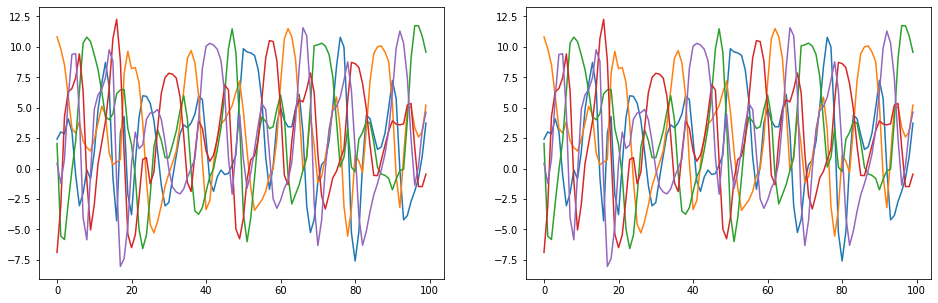

In [10]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[1].plot(X_np[:100])
plt.show()

In [11]:
# Set up model
if device.type == 'cpu':
    clstm = cLSTM(p, hidden=10)
else:
    clstm = cLSTM(p, hidden=10).cuda(device=device) # GPU

In [12]:
# Train with GISTA
check_every = 100
train_loss_list, train_mse_list = train_model_gista(
    clstm, X, lam=0.12, lam_ridge=1e-4, lr=0.005, max_iter=20000, check_every=check_every, truncation=5)

KeyboardInterrupt: 

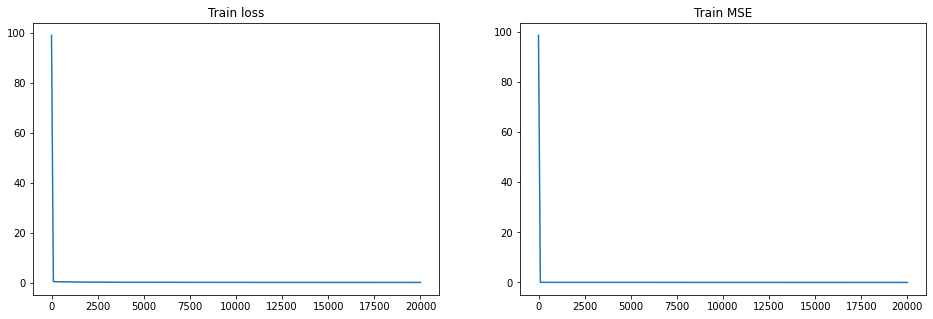

In [17]:
# Loss function plot
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))

axarr[0].plot(check_every * np.arange(len(train_loss_list)), train_loss_list)
axarr[0].set_title('Train loss')

axarr[1].plot(check_every * np.arange(len(train_mse_list)), train_mse_list)
axarr[1].set_title('Train MSE')

plt.show()

[[1 1]
 [1 1]]
[[1 1]
 [1 1]]
True variable usage = 100.00%
Estimated variable usage = 100.00%
Accuracy = 100.00%


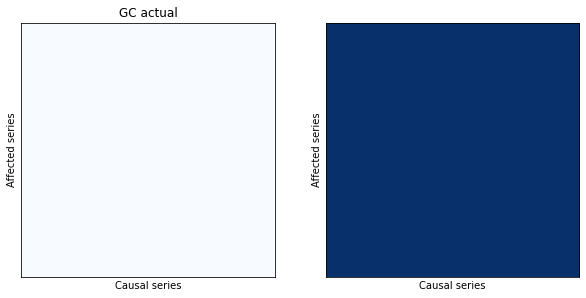

In [18]:
# Verify learned Granger causality
GC_est = clstm.GC().cpu().data.numpy()
print(GC)
print(GC_est)
print('True variable usage = %.2f%%' % (100 * np.mean(GC)))
print('Estimated variable usage = %.2f%%' % (100 * np.mean(GC_est)))
print('Accuracy = %.2f%%' % (100 * np.mean(GC == GC_est)))

# Make figures
fig, axarr = plt.subplots(1, 2, figsize=(10, 5))
axarr[0].imshow(GC, cmap='Blues')
axarr[0].set_title('GC actual')
axarr[0].set_ylabel('Affected series')
axarr[0].set_xlabel('Causal series')
axarr[0].set_xticks([])
axarr[0].set_yticks([])

axarr[1].imshow(GC_est, cmap='Blues', vmin=0, vmax=1, extent=(0, p, p, 0))
axarr[1].set_ylabel('Affected series')
axarr[1].set_xlabel('Causal series')
axarr[1].set_xticks([])
axarr[1].set_yticks([])

# Mark disagreements
for i in range(p):
    for j in range(p):
        if GC[i, j] != GC_est[i, j]:
            rect = plt.Rectangle((j, i-0.05), 1, 1, facecolor='none', edgecolor='red', linewidth=1)
            axarr[1].add_patch(rect)

plt.show()